# Chest X-Ray (Pneumonia): Analyzing the Dataset

This Notebook analyzes the X-Ray dataset \
For further information on this work see the article https://arxiv.org/abs/1711.05225 which is one of the first articles on this subject \
Download the whole dataset from the provided link
Check Kaggle competition as well : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

### Dataset Information

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [1]:
import pandas as pd       
import matplotlib as mat

import numpy as np
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
pd.options.display.max_colwidth = 100

import random
import os
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import glob
import cv2
from PIL import Image

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42
SPLIT_TRAIN = 70     # How to split Train / Test+validation
SPLIT_TEST = 50      # How to split Test  / Validation

In [3]:
# folder input structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------PNEUMONIA
#                  !-------------NORMAL
#
main_path = "./chest_xray_data/"

normal = glob.glob(main_path+"/normal/*.jpeg")
pneumo = glob.glob(main_path+"/pneumonia/*.jpeg")

print('There are normal', len(normal), 'images')
print('There are pneumonia', len(pneumo), 'images')

There are normal 1583 images
There are pneumonia 4273 images


In [4]:
# Randomize and split datasets into Test / Val / Train
# Creates folders 
# If folder exists it  wipes it
#code
#    !------ chest_xray_data
#                  !-------------train
#                          !-------------normal
#                          !-------------pneumonia
#                  !-------------test
#                          !-------------normal
#                          !-------------pneumonia
#                  !-------------val
#                          !-------------normal
#                          !-------------pneumonia
def create_dir(path):
   """ Creates a directory. If it exists wipes it clean

   Keyword arguments:
   path -- directory path to be created
   """
   if os.path.exists(path):
      print('directory', path, 'exists it has not been created')
      # if it exists wipes it clean  
      files = glob.glob(path+"/*.jpeg")
      for f in files:
         os.remove(f)
   else:
      os.makedirs(path)
   return
new_dirs = ['TRAIN', 'TEST', 'VALIDATION']
class_dirs = ['NORMAL', 'PNEUMONIA']

for d in new_dirs:
    create_dir(main_path + d)
    for d2 in class_dirs:
        create_dir(main_path + d +"/"+ d2)

train_normal_size = int(len(normal)*SPLIT_TRAIN/100)
train_pneumo_size = int(len(pneumo)*SPLIT_TRAIN/100)
test_normal_size = int((len(normal)-train_normal_size)*SPLIT_TEST/100)
test_pneumo_size = int((len(pneumo)-train_pneumo_size)*SPLIT_TEST/100)
val_normal_size = test_normal_size
val_pneumo_size = test_pneumo_size
print('size of total images: normal', len(normal), 'pneumonia', len(pneumo))
print('size of train images: normal', train_normal_size, 'pneumonia', train_pneumo_size)
print('size of test images: normal', test_normal_size, 'pneumonia', test_pneumo_size)
print('size of val images: normal', val_normal_size, 'pneumonia', val_pneumo_size)
#
random.shuffle(normal)
random.shuffle(pneumo)
# copy files to new directories

#train_normal_size

list_files = normal[0:train_normal_size]
for f in list_files:
   os.system('cp ' + f + ' '+ main_path + 'TRAIN/NORMAL/')
list_files = normal[train_normal_size:train_normal_size+test_normal_size]
for f in list_files:
   os.system('cp ' + f + ' '+ main_path + 'TEST/NORMAL/') 
list_files = normal[train_normal_size+test_normal_size:len(normal)]
for f in list_files:
   os.system('cp ' + f + ' '+ main_path + 'VALIDATION/NORMAL/') 

list_files = pneumo[0:train_pneumo_size]   
for f in list_files:
   os.system('cp ' + f + ' '+ main_path + 'TRAIN/PNEUMONIA/')
list_files = pneumo[train_pneumo_size:train_pneumo_size+test_pneumo_size]
for f in list_files:
   os.system('cp ' + f + ' '+ main_path + 'TEST/PNEUMONIA/')
list_files = pneumo[train_pneumo_size+test_pneumo_size:len(pneumo)]
for f in list_files:
   os.system('cp ' + f + ' '+ main_path + 'VALIDATION/PNEUMONIA/')   


directory ./chest_xray_data/TRAIN exists it has not been created
directory ./chest_xray_data/TRAIN/NORMAL exists it has not been created
directory ./chest_xray_data/TRAIN/PNEUMONIA exists it has not been created
directory ./chest_xray_data/TEST exists it has not been created
directory ./chest_xray_data/TEST/NORMAL exists it has not been created
directory ./chest_xray_data/TEST/PNEUMONIA exists it has not been created
directory ./chest_xray_data/VALIDATION exists it has not been created
directory ./chest_xray_data/VALIDATION/NORMAL exists it has not been created
directory ./chest_xray_data/VALIDATION/PNEUMONIA exists it has not been created
size of total images: normal 1583 pneumonia 4273
size of train images: normal 1108 pneumonia 2991
size of test images: normal 237 pneumonia 641
size of val images: normal 237 pneumonia 641


In [5]:
# creation of 3 dataframes train, test, val for easy handling ana analysis

train_normal = glob.glob(main_path+"TRAIN/NORMAL/*.jpeg")
train_pneumo = glob.glob(main_path+"TRAIN/PNEUMONIA/*.jpeg")

test_normal = glob.glob(main_path+"TEST/NORMAL/*.jpeg")
test_pneumo= glob.glob(main_path+"TEST/PNEUMONIA/*.jpeg")

val_normal = glob.glob(main_path+"VALIDATION/NORMAL/*.jpeg")
val_pneumo = glob.glob(main_path+"VALIDATION/PNEUMONIA/*.jpeg")

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumo])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumo)]), 
                        columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumo])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumo)]), 
                       columns = ['class'])
df_test['image'] = [x for x in test_list]

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumo])

df_val= pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumo)]), 
                     columns = ['class'])
df_val['image'] = [x for x in val_list]
print('TRAIN shape:', df_train.shape, 'TEST shape:', df_test.shape, 'VALIDATION shape', df_val.shape)

TRAIN shape: (4099, 2) TEST shape: (878, 2) VALIDATION shape (879, 2)


### Data Exploration

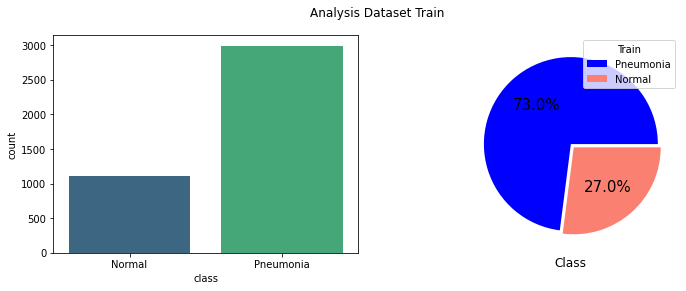

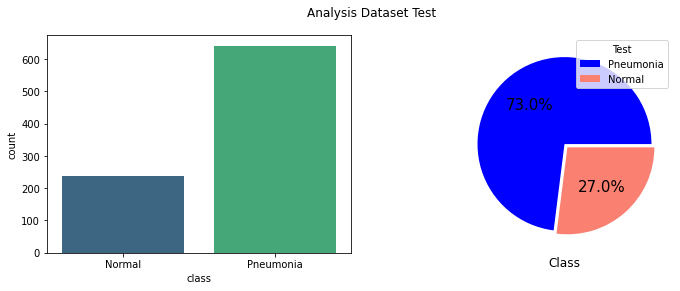

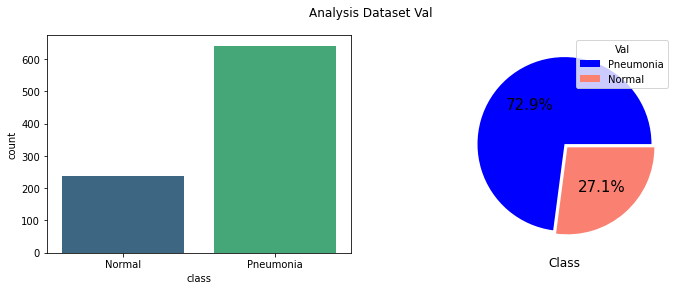

In [6]:
# Visualizes dataframe structure with 2 plots

def visualizing_data(df, Name_title):

   fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    
   fig.suptitle('Analysis Dataset '+ Name_title)
   sns.countplot(x='class', data=df, palette="viridis", ax = axes[0])
   axes[0] = plt.xlabel("Class", fontsize= 12)


   axes[1] = plt.pie(df['class'].value_counts(), labels = ['',''],colors = ['blue','salmon'], 
                      explode = [0,0.05], textprops = {"fontsize":15},autopct='%1.1f%%')
#   axes[0].set_suptitle('pollo')
   axes[1]= plt.legend(labels=['Pneumonia', 'Normal'])
   axes[1].set_title(Name_title)
   plt.show()
   return

visualizing_data(df_train,'Train') 
visualizing_data(df_test,'Test') 
visualizing_data(df_val,'Val')    

### Internal structure of the raw data

In [7]:
sample_image = cv2.imread(df_train.iloc[0]['image'])

print('Raw image shape :', sample_image.shape)


Raw image shape : (1329, 1636, 3)


In [8]:
df_train['matrix'] = df_train['image'].apply(lambda x: np.asarray(Image.open(x)))
df_train['shapes'] = df_train['matrix'].apply(lambda x: x.shape)

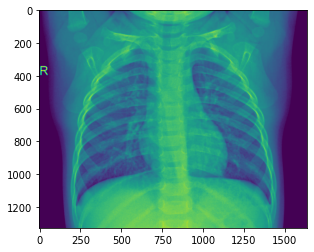

In [9]:
sample_image = df_train.iloc[0]['matrix']
imshow(np.asarray(sample_image))

In [10]:
df_train['matrix'] = df_train['image'].apply(lambda x: cv2.imread(x))
df_train['shapes'] = df_train['matrix'].apply(lambda x: x.shape)

In [11]:
# images come on different sizes
df_train['shapes']

0       (1329, 1636, 3)
1       (1051, 1376, 3)
2       (1229, 1600, 3)
3        (747, 1298, 3)
4       (1480, 1858, 3)
             ...       
4094      (568, 944, 3)
4095    (1008, 1448, 3)
4096     (947, 1426, 3)
4097     (792, 1264, 3)
4098      (560, 880, 3)
Name: shapes, Length: 4099, dtype: object

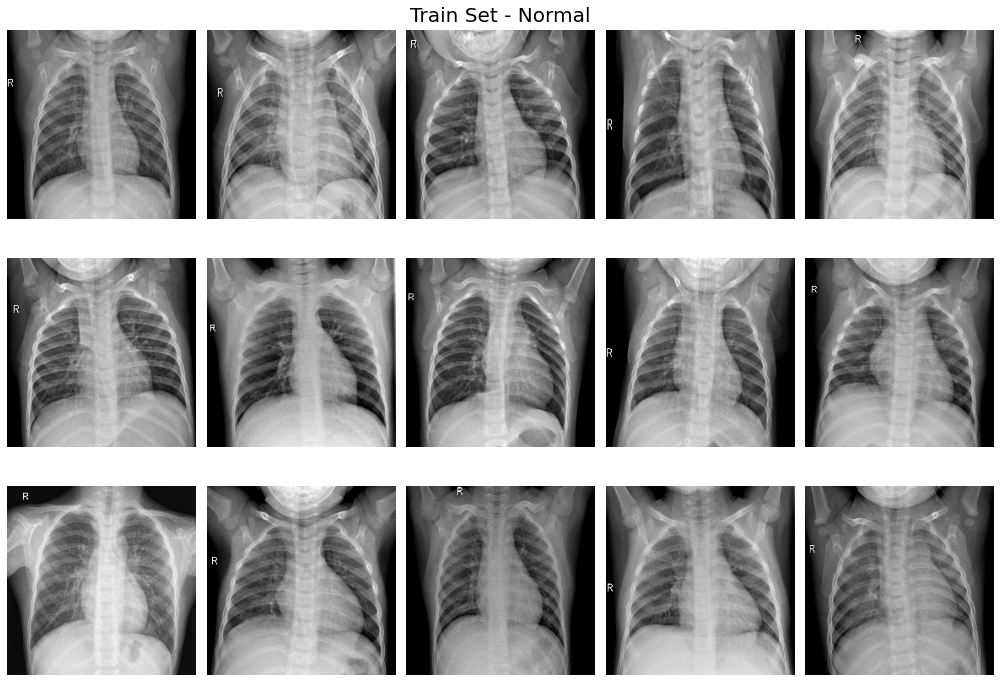

In [12]:
#Train Set - Normal

plt.figure(figsize=(14,10))

for i in range(0, 15):
    plt.subplot(3,5,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Train Set - Normal', size=20)

plt.show()

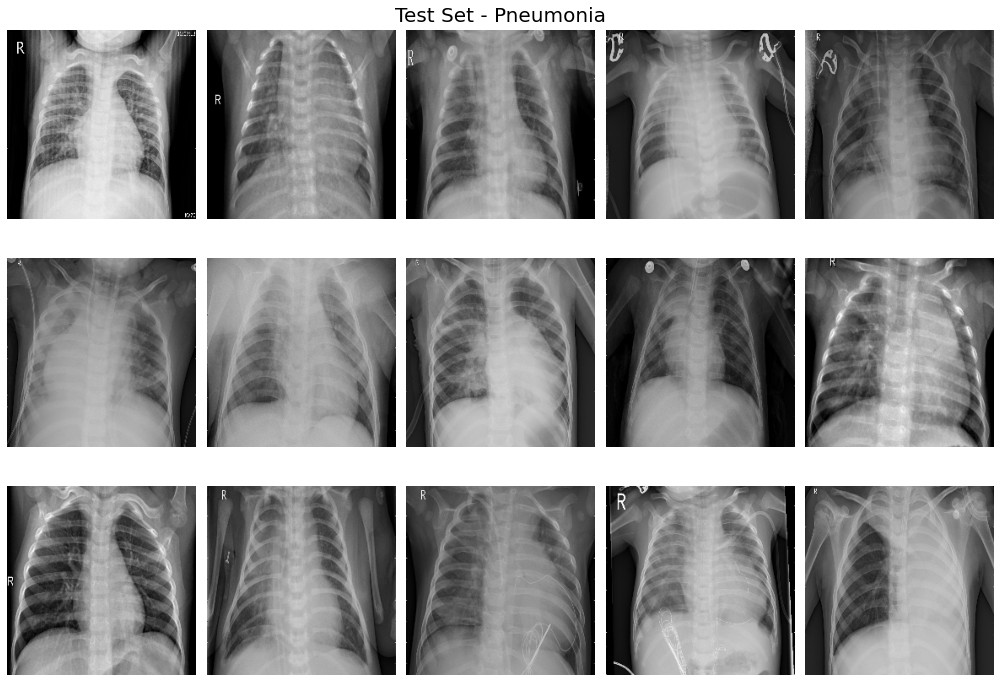

In [13]:
# Train Set - Pneumonia

plt.figure(figsize=(14,10))

for i in range(0, 15):
    plt.subplot(3,5,i + 1)
    img = cv2.imread(train_pneumo[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.suptitle('Test Set - Pneumonia', size=20)

plt.show()

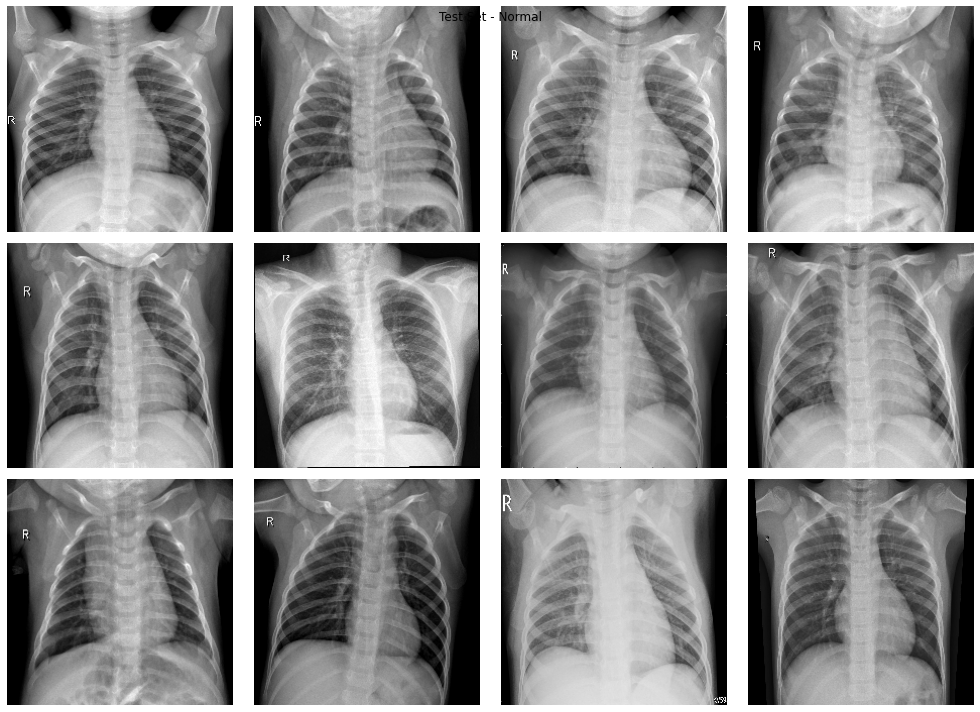

In [14]:
# test set normal
plt.figure(figsize=(14,10))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Test Set - Normal')

plt.show()

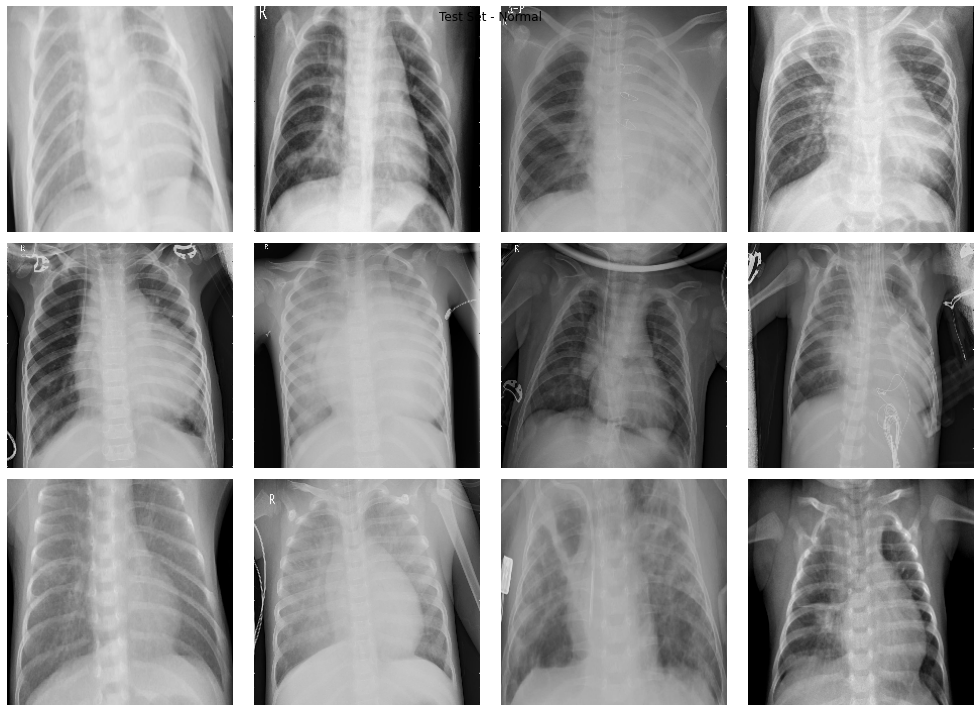

In [15]:
# Test Set - Pneumonia

plt.figure(figsize=(14,10))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumo[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Test Set - Normal')

plt.show()

In [16]:
#EOF